### Overview

### By Cities

<ul>
    <li>Create a new dataframe by wrangling dat to identify for each city, across all carriers:
        <ol>
            <li>weekly total number of movements (arrivals plus departures).
            <li>weekly capacity.
            <li>weekly estimated passengers
        </ol>
</ul>

Identify the top cities that account for 80% of each weekly totals.

#### Top Cities by Weekly Movements

#### Top Cities by Weekly Capacity

#### Top Cities by Weekly Estimated Passengers

----- From Here ----------

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import make_interp_spline, BSpline

## Get Data

In [2]:
with open('./data/processed/codes_to_city_dict.txt', 'rb') as handle:
    codes_to_city = pickle.loads(handle.read())
dat = pd.read_pickle('./data/processed/final/all-sched-enriched.pkl')
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,False,True
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,True,True,True,True,True,False,True


In [3]:
weeklies_ = ['weekly_flights', 'weekly_capacity', 'weekly_est_pass']

from_flights = dat.groupby(['from'])[weeklies_].sum()
to_flights = dat.groupby(['to'])[weeklies_].sum()

sdat = pd.concat([from_flights, to_flights], axis = 1, ignore_index = True)
sdat = sdat.fillna(0, axis = 1, downcast = 'infer') # if there are no flights either from or to a city, 
                                                    # replace NA by 0
sdat = sdat.rename(columns = {0:'from_weekly_flights', 
                                            3:'to_weekly_flights',
                                            1:'from_weekly_capacity',
                                            4:'to_weekly_capacity',
                                            2:'from_weekly_est_pass',
                                            5:'to_weekly_est_pass'}, errors = 'raise')

sdat['total_weekly_mvmnts'] = sdat.apply(lambda row: row.from_weekly_flights + row.to_weekly_flights,axis = 1)
sdat['total_weekly_capacity'] = sdat.apply(lambda row: row.from_weekly_capacity + row.to_weekly_capacity, 
                                           axis = 1)
sdat['total_weekly_est_pass'] = sdat.apply(lambda row: row.from_weekly_est_pass + row.to_weekly_est_pass, 
                                           axis = 1)

sdat.head()

,from_weekly_flights,from_weekly_capacity,from_weekly_est_pass,to_weekly_flights,to_weekly_capacity,to_weekly_est_pass,total_weekly_mvmnts,total_weekly_capacity,total_weekly_est_pass
AGR,4,280,218,4,280,218,8,560,436
AGX,7,490,383,7,490,383,14,980,766
AIP,7,546,500,7,546,500,14,1092,1000
AJL,11,1342,1046,24,3782,3223,35,5124,4269
AMD,764,124123,109080,750,120574,105987,1514,244697,215067


In [6]:
def top_cities_feature(df, feature, threshold = 0.8):
    '''
    
    Returns the list top cities (by code) that account for threshold percentage of weekly total of the 
    desired feature.
    
    '''
    
    df = df.sort_values(by = [feature], ascending = False)   
    total = df[feature].sum()
    top_cities = round(df[feature].cumsum()/total, 2)
        
    return top_cities[top_cities <= threshold].index.tolist()

In [8]:
def fill_missing(series, slots, na_val):
    
    '''
    
    In a series with an expected numerically ascending index, identifies if a particular index value
    is missing and inserts a new entry with such missing index value with the desired na_val.
    
    Finally, reorder the new series to ensure that the inserted index values are in their appropriate 
    position
    
    '''
    
    if series.shape[0] != slots:
        missing_idx = list(set(np.arange(1, slots+1, 1)).difference(series.index))
        for i in missing_idx:
            series[float(i)] = na_val
    
    series = series.sort_index()
    return series

In [10]:
def city_time_metric_count(df, metric, city = 'ALL'):
    
    ''' 
    
    For a city and for a traffic metric (movements, capacity, estimated passengers), returns the sum 
    of metric over:
        flights into the city
        flights outof the city
        total for the city
        
    When combined across all cities, for any day, the total value of the metric for flights in would be the 
    same as the total value of the metric for flights out (for e.g. the total numnumber of arrivals must be 
    equal to the total number of departures). 
    
    However, this may not be true when considering a particular city, 
    i.e. the total number of arrivals in a city may not be the same as the total number of departures. 
    
    '''
    
    _in =[]
    _out = []
    _total = []
    
    if city == 'ALL':
        _out = (df.groupby(['from_time_slot'])[metric].sum())
        _out = fill_missing(_out, 48, 0)
        _total = [value*2 for value in _out]
    
    else:
        idx = [i for i in dat.index if dat['from'][i] == city or dat['to'][i] == city]
        sdat = dat.iloc[idx, :]

        idx_in = [i for i in sdat.index if sdat['to'][i] == city]     # flights into the city
        idx_out = [i for i in sdat.index if sdat['from'][i] == city]  # flights out of the city

        _in = (sdat.loc[idx_in, :].groupby(['to_time_slot'])[metric].sum())
        _in = fill_missing(_in, 48, 0)
        _out = (sdat.loc[idx_out, :].groupby(['from_time_slot'])[metric].sum())
        _out = fill_missing(_out, 48, 0)
        _total = [sum(x) for x in zip(_in, _out)]
    
    return _in, _out, _total
    

In [31]:
def pass_traffic_spread(traffic, spread_slots, pass_dir_in = False):
    
    traffic_adj = pd.Series(data = 0, index = traffic.index, dtype = 'float')
    
    if pass_dir_in == True:
        for i in range(1, 49):              # spreading the passengers at the airport for incoming flights
            dist_ = traffic[i]/spread_slots
            for j in range(i+1, i+3):
                if j > 48: j = j - 48
                traffic_adj[j] += dist_
    else:
        for i in range(1, 49):              # spreading the passengers at the airport for outgoing flights
            dist_ = traffic[i]/spread_slots
            for j in range(i-spread_slots, i):
                if j < 1: j = 48 + j
                traffic_adj[j] += dist_
                    
    return traffic_adj

In [32]:
#top_cities = top_cities_feature(sdat, 'total_weekly_est_pass')
pass_in, pass_out, pass_total = city_time_metric_count(dat, 'weekly_est_pass', 'BLR')

pass_in_adj = pass_traffic_spread(pass_in, 2, True)
pass_out_adj = pass_traffic_spread(pass_out, 4)
pass_total_adj = [sum(x) for x in zip(pass_in_adj, pass_out_adj)]

In [33]:
def plot_distbn(mvmnts, freq, city = 'ALL', spline_pts = 100, smoothing_param = 2):
    
    '''
    
    Plots a smooth curve (spline) of either Day-of-Week or Time-of-Day distribution of movements.
    
    mvmnts - List of aggregate (days of week or timeslot of day) movements
    freq - either 'day' for Day-of-Week distribution or 'time' for Time-of-Day distribution
    city - either 'ALL' for all cities combined or the relevant IATA code for a specific city
    spline_pts, smoothing_param - parameters of the spline drawn
    
    '''
    
    if freq == 'day':
        x_orig = np.arange(1, 8 ,1)
        x_augm = np.linspace(1, 7, spline_pts)
        plt.xlabel('Day of the Week')
        if city == 'ALL': plt.title('Daily Total Movements - All Cities')
        else: plt.title('Daily Total Movements in %s' % codes_to_city[city])
    else:
        x_orig = np.arange(1, 49 ,1)
        x_augm = np.linspace(1, 48, spline_pts)
        plt.xlabel('Hour of the Day')
        plt.xticks(np.arange(0, 49, 2), labels = np.arange(0, 25, 1)) # to get 24 hours on the x-axis
        plt.axvline(x = 12, color = 'black', linestyle = '--')         # 6 a.m.
        plt.axvline(x = 24, color = 'black', linestyle = '--')         # 12 noon
        plt.axvline(x = 36, color = 'black', linestyle = '--')         # 6 p.m.
        if city == 'ALL': plt.title('Average Hourly Movements In a Day - All Cities')
        else: plt.title('Average Hourly Movements In a Day in %s' % codes_to_city[city])
        
    spline = make_interp_spline(x_orig, mvmnts, k = smoothing_param)
    y_axis = np.maximum(np.zeros(spline_pts), spline(x_augm))       # prevent y from taking a negative value
    plt.plot(x_augm, y_axis)
    plt.ylabel('Arrivals + Departures')
    
    return        

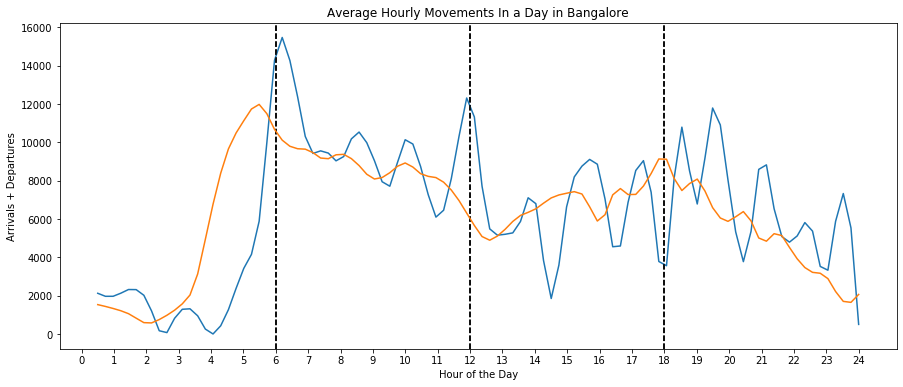

In [35]:
plt.figure(figsize = (15, 6))
#plt.subplot(2,1,1)
plot_distbn(pass_out, freq = 'time', city = 'BLR', spline_pts = 100, smoothing_param = 2)
#plt.subplot(2,1,2)
plot_distbn(pass_out_adj, freq = 'time', city = 'BLR', spline_pts = 100, smoothing_param = 2)

plt.show()

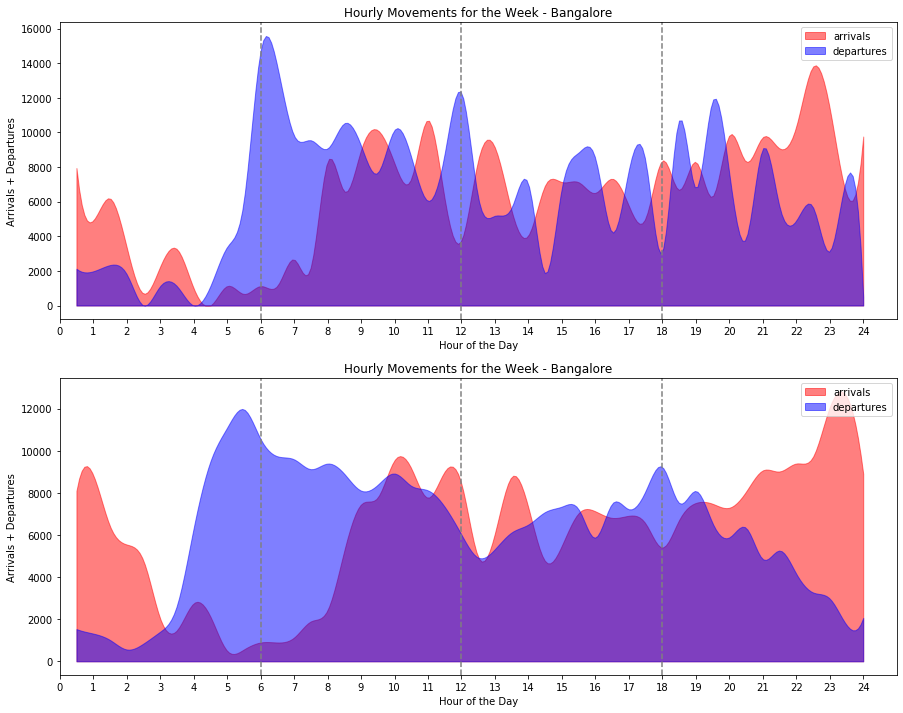

In [49]:
'''city_code = 'BLR'

timeslot_arr = []
timeslot_dep = []

idx = [i for i in dat.index if dat['from'][i] == city_code or dat['to'][i] == city_code]
sdat = dat.iloc[idx, :]

idx_in = [i for i in sdat.index if sdat['to'][i] == city_code] # flights into the city
idx_out = [i for i in sdat.index if sdat['from'][i] == city_code]  # flights out of the city

# Timeslot wise passenger traffic on incoming flights
pass_in_timeslot = (sdat.loc[idx_in, :].groupby(['to_time_slot'])['weekly_est_pass'].sum())
pass_in_timeslot = fill_missing(pass_in_timeslot, 48, 0)
#Timeslot wise passenger traffic on outgoing flights
pass_out_timeslot = (sdat.loc[idx_out, :].groupby(['from_time_slot'])['weekly_est_pass'].sum())
pass_out_timeslot = fill_missing(pass_out_timeslot, 48, 0)'''

'''

We make some informed assumptions:
    Incoming passengers at an airport start departing from the airport, and do so evenly, in 2 slots post the 
to_time_slot i.e. the timeslot in which their flight arrives.
    Outgoing passengers from an airport start arriving at the airpot and do so evenly in 4 slots prior to the 
from_time_slot i.e. the timeslot in which their flight leaves. 

We adjust the timeslot passenger traffic values to reflect this spread.

'''

in_slots = 2; out_slots = 4

pass_in_timeslot_adj = pd.Series(data = 0, index = pass_in_timeslot.index, dtype = 'float')
pass_out_timeslot_adj = pd.Series(data = 0, index = pass_out_timeslot.index, dtype = 'float')
        
for i in range(1, 49):              # spreading the passengers at the airport for incoming flights
    dist_ = pass_in_timeslot[i]/in_slots
    for j in range(i+1, i+3):
        if j > 48: j = j - 48
        pass_in_timeslot_adj[j] += dist_
        
for i in range(1, 49):              # spreading the passengers at the airport for outgoing flights
    dist_ = pass_out_timeslot[i]/out_slots
    for j in range(i-out_slots, i):
        if j < 1: j = 48 + j
        pass_out_timeslot_adj[j] += dist_

plt.figure(figsize = (15, 12))

plt.subplot(2, 1, 1)
plot_hourly(pass_in_timeslot, pass_out_timeslot, codes_to_city[city_code])

plt.subplot(2, 1, 2)
plot_hourly(pass_in_timeslot_adj, pass_out_timeslot_adj, codes_to_city[city_code])

plt.show()


### Time-of-Day Distribution by Passenger Movement